<h1><center><u><font color="red"> Solution of Tutorial-1 </font></u> </center></h1> 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Global variables
global MSUN,  PC, PI, COS

# Solar Mass in seconds
# GM/C^3
MSUN = 4.925491025543575903411922162094833998e-6

# One Parsec in seconds
MPC = 1.0292712503e14

# PI
PI = np.pi

# COS
COS = np.cos

In [0]:
def td_newtonian_chirp(m1, m2, fnot, phi_not, distance, time_range):
    """
    Compute time domain newtonian chirp h(t)
    Parameters
    ----------
    m1: float
        Mass of the compact object 1
    m2: float
        Mass of the compact object 2
    fnot: float
          Startig frequency of the Signal
    phi_not: float
             Phase at some time.
    distance: float
              Luminosity distance D to the source
    time_range: array-like
                Time array of the signal in sec
    Return
    ------
    td_nchirp: array-like
               Time domain Newtonian chirp h(t)
    idx: array-like
         Indices required for plotting
    """
    
    # Scaling
    m1 *= MSUN
    m2 *= MSUN
    distance *= MPC
    
    # Total Mass
    Total_mass = m1 + m2
    
    # Reduced Mass
    Reduced_mass = m1 * m2 / Total_mass
    
    # Chirp Mass
    Chirp_mass = Reduced_mass**(3./5.) * Total_mass**(2./5.)

    # Duration of Coalescence time
    tc_duration = 5. / (256. * (PI * fnot)**(8./3.) * Chirp_mass**(5./3.))

    # Index of time range, where coalescence time is greater than the time range
    idx = time_range < tc_duration 
    # Coalescence time array
    tc_array = time_range[idx]
    # Initialize time domain Newtonian chirp array
    td_nchirp = np.zeros(len(time_range))

    # Frequency evolution
    freq_evol = (Chirp_mass * fnot**9.) ** (1./8.)
    freq_evol /= ((Chirp_mass * fnot)**(1./3.) - 256. * fnot**3. * Chirp_mass**2. * PI**(8./3.) * tc_array / 5.) ** (3./8.)

    # Amplitude
    amplitude = (4. * Chirp_mass**(5./3.) * PI**(2./3.) * freq_evol**(2./3.)) / distance

    # Phase
    phase = phi_not - 2. * (1./(256. * (PI*Chirp_mass*fnot) ** (8./3.)) - tc_array / (5. * Chirp_mass)) ** (5./8.)

    # Time domain Newtonian chirp
    td_nchirp[idx] = amplitude * COS(phase)

    # ----------------------------------------------------------------------- #
    # ----------------------------------------------------------------------- #
    print("------------------------------------------------------------------")
    print(" Chirp Mass (Solar Mass sec)             :", Chirp_mass)
    print(" Coalescence time (sec)                  :", tc_duration)
    print(" Frequency evolution - First data point  :", freq_evol[0]) 
    print(" Amplitude - First data point            :", amplitude[0])
    print(" Phase - First data point                :", phase[0])
    print(" TD Newtonian chirp - First data point   :", td_nchirp[0])
    print("------------------------------------------------------------------")

    return td_nchirp, idx, tc_duration

---
<h1><center><u><font color="red">Tutorial 2 </font></u> </center></h1> 

<h1><center><font color="blue"> Simple Matched Filter - Cross Correlation </font></center></h1> 

Let us construct a simple matched filter (non-optimal) by simply cross-correlating the noisy data - which has the GW signal deeply embedded in it - with a template.

The cross correlation function $R(\tau)$ for two time series vectors $f(t)$ and $\hat{h}(t)$ for a time shift $\tau$ is defined as,

$$ R(\tau) = \frac{1}{T}\int_{-T}^{T} f(t) * \hat{h}^*(t-\tau)\ dt, \ \ \ limit \ T \rightarrow \infty$$

Here, $^*$ denotes the complex conjugate and the template vector $\hat{h} = \frac{h}{||h||}$. If $\sigma^2$ is the variance of noise then the norm $||h||$ is defined as,

$$ ||h||^2 = \frac{1}{t_c}\int_0^{t_c} \frac{|h(t)|^2}{\sigma^2}\ dt. $$

---

<center><u><b><h1><font color="blue"> Task </center></u></b></h1>

Create a Gaussian noise vector (with mean=0 and sigma=2e-21) and inject the GW template in it at t = 6 sec. Visualize the injected signal and see if you can spot it. 

Cross correlate this data with the normalized template. Plot the cross correlation.

---

In [14]:
# Duration of the signal
tduration = 16
Fs = 4096
sigma = 2e-21
dt = 1./Fs

# create a time vector 
time_array = np.arange(0, tduration, dt)

# Time Domain Newtonian Chirp Signal
chirp, index =td_newtonian_chirp(m1= 20, m2=10, fnot=30, phi_not=0, distance=100, time_range=time_array)

# create noise vector
noise = np.random.normal(scale=sigma, size=time_array.shape)

# get a data vector by adding the template in noise vector at t = 6 sec
data = noise.copy()
data[6*Fs : 6*Fs+len(chirp[index])] += chirp[index]

------------------------------------------------------------------
 Chirp Mass (Solar Mass sec)             : 5.9929862125114186e-05
 Coalescence time (sec)                  : 1.1568265168522474
 Frequency evolution - First data point  : 30.0
 Amplitude - First data point            : 7.386687025877906e-22
 Phase - First data point                : -348.8906579348046
 TD Newtonian chirp - First data point   : -7.275311050366607e-22
------------------------------------------------------------------


Text(0, 0.5, 'strain')

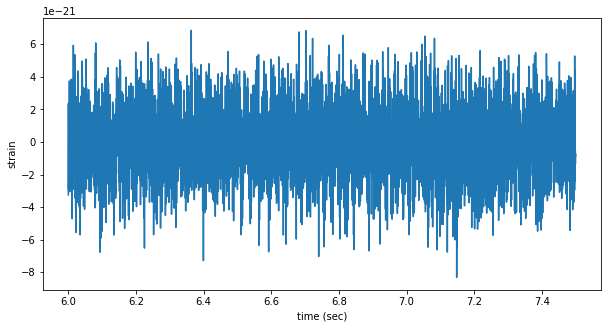

In [15]:
t_s = 6.
t_e = 7.5

# Plot the region in which chirp lies
plt.figure(figsize=(10,5))
plt.plot(time_array[int(t_s*Fs) : int(t_e*Fs)], data[int(t_s*Fs) : int(t_e*Fs)])
plt.xlabel('time (sec)')
plt.ylabel('strain')

## Calculation of Cross Correlation

In [0]:
# initialize the cross correlation vector
R_tau = np.zeros(tduration*Fs)

# cyclically shifting the chirp to get the peak in SNR at the location of GW merger
shifted_chirp = np.roll(chirp, -len(chirp[index]))

# Calculating the norm
norm = abs(chirp[index])**2./sigma**2.
norm = norm.sum() * dt / tduration
norm **= 0.5

# Weighing the shifted_chirp to get template
template = shifted_chirp / norm

In [0]:
# for each step 'i' in time slide
for i in range(tduration*Fs):
    R_tau[i] = (data*np.roll(template, i)).sum()

R_tau *= dt / tduration

Text(0, 0.5, '$R(\\tau)$')

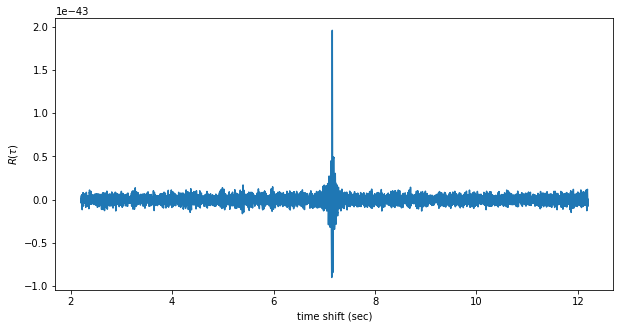

In [20]:
t_0 = 7.2
width = 5
id_s = int((t_0-width)*Fs)
id_e = int((t_0+width)*Fs)

# Plot cross correlation
plt.figure(figsize=(10,5))
plt.plot(time_array[id_s:id_e], R_tau[id_s:id_e])
plt.xlabel('time shift (sec)')
plt.ylabel(r'$R(\tau)$')

<h3><center><u> <font color="brown"> Stuff you may need to use </font> </u></center><h3>

*   Array creation

```
np.arange(0., 10., 2.)
>>> array([0., 2., 4., 6., 8.])

np.linspace(0, 10, 11)
>>> array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

np.zeros((2,3))                                                                             
>>> array([[0., 0., 0.],
       [0., 0., 0.]])


```


*   Sample points from a Normal distribution with mean (loc), scale (sigma) and size (shape of array)

```

np.random.normal(loc=0.0, scale=1.0, size=(2,10))
>>> array([[ 0.39133178, -2.21499361, -1.83827862, -0.15723072, -2.14407863,
         0.31868262, -1.0411618 ,  0.28885505,  1.74539959,  1.4932617 ],
       [ 0.07768785,  0.06267242,  0.81416789, -1.96280913,  0.81218201,
        -0.16782135, -1.66461222, -0.61233767,  0.86096387, -1.45719472]])

```
*  Properties of a numpy array

```

a = np.array([-1, 2, 3, 5, -2, 7])
a.sum()
>>> 14

abs(a)
>>> array([1, 2, 3, 5, 2, 7])

# array slicing 
a[2:4]
>>> array([3, 5])

np.roll(a, 3)
>>> array([ 5, -2,  7, -1,  2,  3])

```

*  for loop

```
for i in range(3):
    print(i)
>>> 0
    1
    2

```